In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler


from sklearn import datasets, linear_model
from scipy.stats import linregress

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import pprint

In [2]:
# import our own functions
import rep_drift, visualize_drift

In [3]:
# glabal variables:

n_sessions = 3
n_repeats = 10
n_divs = 30

------------------
### 1. Reproducing Sadeh & Clopath: <span style="color:purple"> across session </span> behavior modulation on the <span style="color:orange"> movie response vector </span>



Sadeh & Clopath's [paper](https://www.biorxiv.org/content/10.1101/2022.01.02.474731v1.full.pdf) aims to ask whether behavior during one repeat of a video has an effect on the varaibility of the representation. Thus the best example to showcase such effect would be to find out a specimen that ran at different speed during the three sessions.

We use container `647155120`. As we plot below the running speed, we can see that it ran the fastest during the 2nd session, ran slowlier the 1st session and the slowliest the 3rd session.

In [4]:
boc = BrainObservatoryCache()

In [5]:
data_sets, ordered_days = rep_drift.get_datasets(boc, 647155120) 
print(ordered_days)

[0 5 6]


In [6]:
dff_vals_container, run_vals_container =  rep_drift.align_response_vals(data_sets)

In [7]:
def plot_run(run_vals):

    fig, ax = plt.subplots(figsize=(14,4))
    colors = plt.cm.summer(np.linspace(0, 1, 10))

    ax.set_ylim([0, 80])
    ax.set_ylabel('cm/s', fontsize = 16)

    ax.text(0, 72, 'Repeats:', fontsize = 14)
    # ax.hlines(0, 0, 29, linestyles= '--', color = 'black')
    for i in range(10):
        ax.plot(run_vals[i,:], color = colors[i])
        ax.text(i+3, 72, i, color = colors[i], fontsize = 14)
    
    plt.show()

Session 0; Day 0


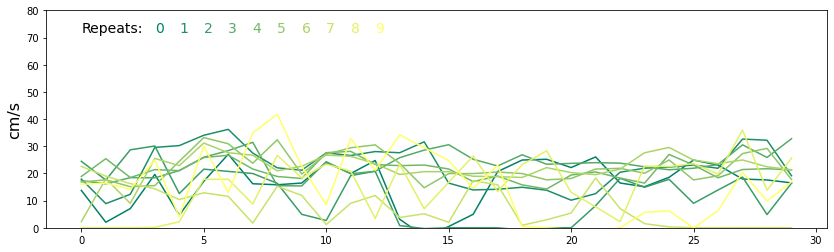

Session 1; Day 5


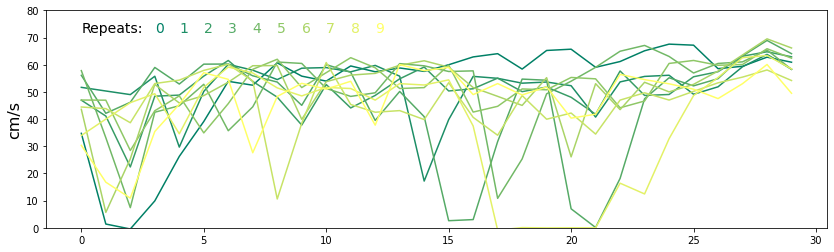

Session 2; Day 6


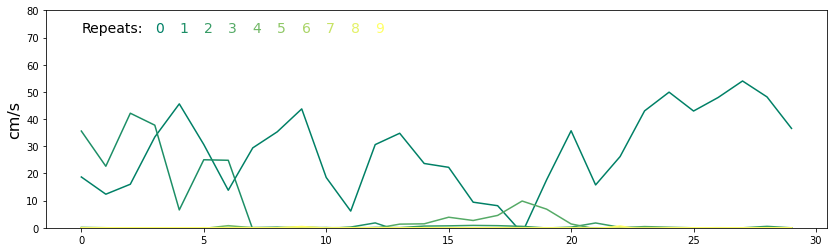

In [8]:
for session_idx in range(n_sessions):
    run_vals = run_vals_container[session_idx]
    print(f'Session {session_idx}; Day {ordered_days[session_idx]}')
    plot_run(run_vals)

In the Pearson Correlation matrix for all response vectors of a session (which is the n_neuron response to one sec stimuli in a single repeat), the diagonals of each repeat submatrix to other repeats' submatries represent the representation similarity of the same stimuli cross the repeats within this session. 

Let's plot the the Pearson Correlation matrix for each session respectively. 

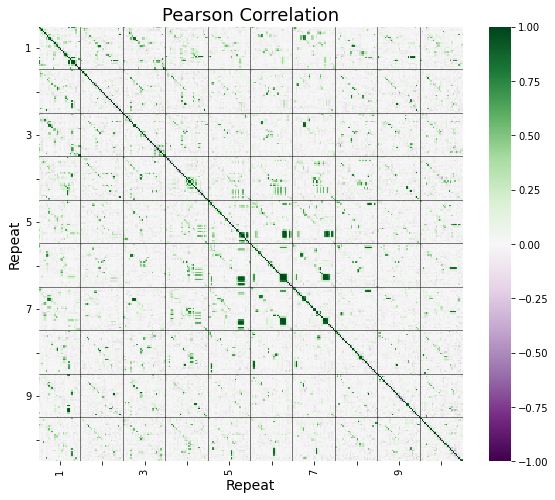

In [9]:
# Session 1: some diagonals look correlated 
cell_ids_0, dff_vals_0, run_vals_0 = rep_drift.get_response_vals(data_sets[0])
corrs_s0, angles_s0 = rep_drift.calc_similarity(dff_vals_0)
visualize_drift.plot_corr(corrs_s0, n_repeat_plot= 10)

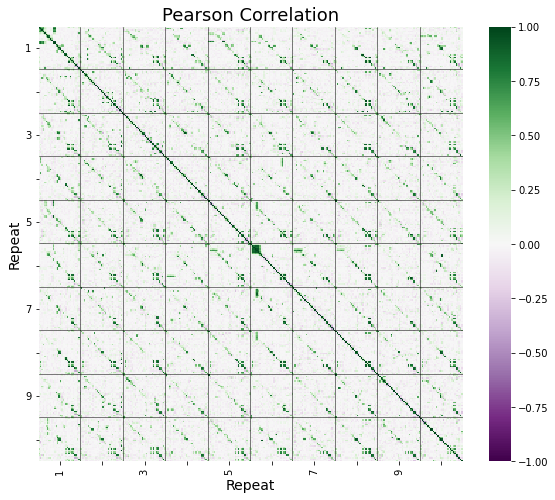

In [10]:
# Session 2: some diagonals look very correlated, and we can almost 'see' parallel lines.
cell_ids_1, dff_vals_1, run_vals_1 = rep_drift.get_response_vals(data_sets[1])
corrs_s1, angles_s1 = rep_drift.calc_similarity(dff_vals_1)
visualize_drift.plot_corr(corrs_s1, n_repeat_plot= 10)

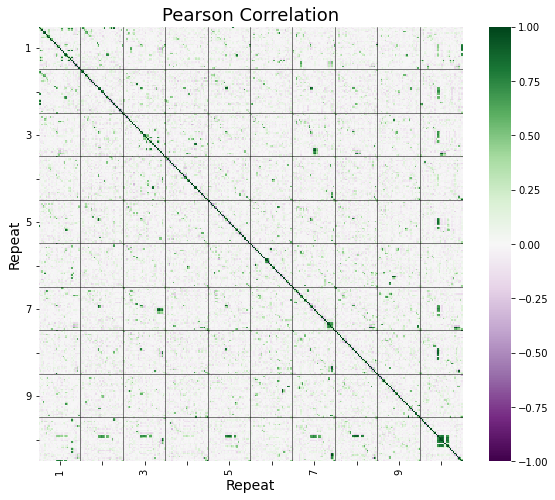

In [11]:
# Session 3: almost all diagonals are gone
cell_ids_2, dff_vals_2, run_vals_2 = rep_drift.get_response_vals(data_sets[2])
corrs_s2, angles_s2 = rep_drift.calc_similarity(dff_vals_2)
visualize_drift.plot_corr(corrs_s2, n_repeat_plot= 10)

This support the claim of the Sadeh & Clopath paper, that "increased pupil diameter and running ... increased the similiarty of responses to the same movie within that block (which means session here)".


Let's investigate this claim using their method too, by looking at similarity between the response vectors for the entire movie across different repeats. 

The representation vector by the entire movie is by concatinating our response vector for each second of the movie on end, which is just a $N$ (neurons) x $M$ (seconds) long vector.

In [12]:
# get data from all three sessions:
dff_vals_all = np.zeros((30, 30, dff_vals_container[0].shape[-1]))
run_vals_all = np.zeros((30, 30))
for session_idx in range(n_sessions):
    dff_vals_all[session_idx*n_repeats:session_idx*n_repeats+n_repeats] = dff_vals_container[session_idx]
    run_vals_all[session_idx*n_repeats:session_idx*n_repeats+n_repeats] = run_vals_container[session_idx]

In [13]:
def z_score_spd(run_vals):
    'z-scoring the running spd'
    scaler = StandardScaler()
    scaler.fit(run_vals)
    run_vals_centered = scaler.transform(run_vals)

    return run_vals_centered 

In [14]:
# z-scoring for all three sessions for the same mouse:
run_vals_all_centered = z_score_spd(run_vals_all)

In [15]:
# response vector for the movie
dff_vals_movie = np.reshape(dff_vals_all, (30, 30*dff_vals_all.shape[-1]))

In [16]:
# per movie mean running speed
run_movie = run_vals_all.mean(axis = 1)
run_movie_centered = run_vals_all_centered.mean(axis = 1)

In [17]:
# corrcoef for the 30 NxM-long response vectors for the movie repeats:
corrs_movie = np.corrcoef(dff_vals_movie)

30
60


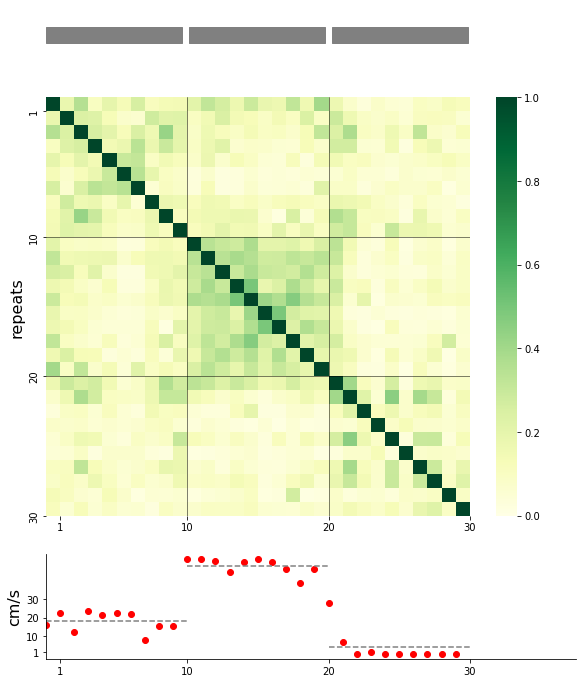

In [18]:
# plot the Pearson Correlation matrix, and the running speed:
fig, ax = plt.subplots(3, 1, figsize=(9.5 , 12), gridspec_kw={'height_ratios': [1, 8, 2]})


ax[0].set_xlim([0, 37])
ax[0].set_ylim([0, 10])
ax[0].add_patch(Rectangle((0, 3), 9.5, 3, color="grey"))
ax[0].add_patch(Rectangle((10, 3), 9.5, 3, color="grey"))
ax[0].add_patch(Rectangle((20, 3), 9.5, 3, color="grey"))

ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].set_xticks([])
ax[0].set_yticks([])


sns.heatmap(corrs_movie, cmap = 'YlGn', vmin = 0, vmax = 1, ax = ax[1])

tick_locs = [1, 10, 20, 30]
ax[1].set_xticks(tick_locs)
ax[1].set_yticks(tick_locs)
tick_labels = tick_locs
ax[1].set_xticklabels(tick_labels)
ax[1].set_yticklabels(tick_labels)

ax[1].set_ylabel('repeats', fontsize = 16)

for session_idx in range(1, n_sessions):
    print(session_idx * n_divs)
    ax[1].axhline((session_idx * n_repeats), c='k', linewidth=0.5)
    ax[1].axvline((session_idx * n_repeats), c='k', linewidth=0.5)

ax[2].scatter(np.arange(30), run_movie, c = 'r')
ax[2].set_xlim([0, 37.5])

ax[2].hlines(run_movie[:10].mean(), 0, 10, color = 'grey', ls = '--')
ax[2].hlines(run_movie[10:20].mean(), 10, 20, color = 'grey', ls = '--')
ax[2].hlines(run_movie[20:30].mean(), 20, 30, color = 'grey', ls = '--')

tick_locs = [1, 10, 20, 30]
ax[2].set_xticks(tick_locs)
ax[2].set_yticks(tick_locs)
tick_labels = tick_locs
ax[2].set_xticklabels(tick_labels)
ax[2].set_yticklabels(tick_labels)

ax[2].set_ylabel('cm/s', fontsize = 16)

ax[2].spines["top"].set_visible(False)
ax[2].spines["right"].set_visible(False)

Response vectors in the 2nd session where the mouse is running fast are the most correlated with each other; followed by the 1st session and the 3rd session.

This plot is the same idea as __Fig. 1b left__ in the Sadeh & Clopath paper. We try to reproduce  __Fig. 1b right__ via regressing the difference in mean running speed to the R-score of the response vectors in the below code.

In [19]:
# let's do run_diff:
run_movie_diff = np.zeros((30,30))

for repeat_idx1 in range(n_repeats):
    for repeat_idx2 in range(n_repeats):
        run_movie_diff[repeat_idx1, repeat_idx2] = np.abs(
            run_movie_centered[repeat_idx1]- run_movie_centered[repeat_idx2])

In [20]:
def upper_tri(M):
    'all values in the upper triangular matrix ignoring diagonal values'
    iu = np.triu_indices(M.shape[0], k = 1)
    M_upper_flattern = M[iu]
    
    return  M_upper_flattern   

In [21]:
run_movie_diff_upper = upper_tri(run_movie_diff)
run_movie_diff_filtered = run_movie_diff_upper[np.where(run_movie_diff_upper != 0)] # ignoring the case when the mouse didn't run
corrs_movie_upper = upper_tri(corrs_movie)
corrs_movie_upper_filtered = corrs_movie_upper[np.where(run_movie_diff_upper != 0)]

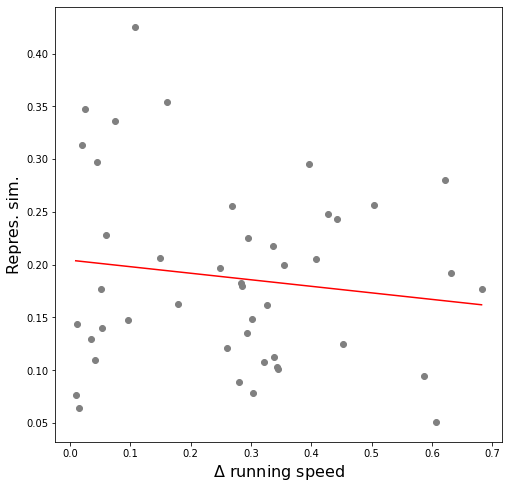

In [22]:
# filter on no-run movies:
reg = linregress(run_movie_diff_filtered, corrs_movie_upper_filtered)

fig, ax  = plt.subplots(figsize=(8,8))
ax.scatter(run_movie_diff_filtered, corrs_movie_upper_filtered, color = 'grey')

reg_x = np.linspace(np.min(run_movie_diff_filtered), np.max(run_movie_diff_filtered), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'r')

ax.set_xlabel('$\Delta$ running speed', fontsize = 16)
ax.set_ylabel('Repres. sim.', fontsize = 16)
# ax.text(2, .8, f'R: {reg.rvalue:.3f}')
# ax.set_ylim([0, 1])

plt.show()

Uh, I wouldn't call it a negative correlation; the reason's probably since there are big-within session varaitions too.

------------------
### 2. Our own way to show modulation: <span style="color:purple"> within session </span> behavior modulation on the <span style="color:orange"> per second stimuli response vector </span>

We are looking for a session where the mouse run for some of the repeats but not for the rest repeats, and best if we see a half half split. We found experiment `571494829` has that: during 5/10 repeats the mouse ran, but the other 5 they look like relatively stayed put.

In [23]:
data_set = boc.get_ophys_experiment_data(571494829)
cell_ids, dff_vals, run_vals = rep_drift.get_response_vals(data_set)

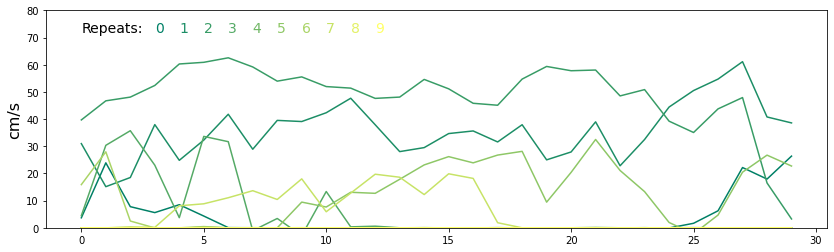

In [24]:
plot_run(run_vals)

In [25]:
# get crrelation matrix and angle matrix:
corrs_s, angles_s = rep_drift.calc_similarity(dff_vals)
run_spd_per_repeat = np.nanmean(run_vals, axis = 1)

# sort the repeats by mean running speed:
run_repeat_sort_idx = np.argsort(run_spd_per_repeat)
print(run_repeat_sort_idx) # from the slowest to the fastest

[9 4 8 6 0 3 7 5 1 2]


In [26]:
# the dicotomy is not that clean; but we can try to bin the in the middle:
print('If we use 5 cm/s as the cut-off then', np.sum(run_spd_per_repeat < 5), 'of 10 repeats the mouse were considered to be running.')

If we use 5 cm/s as the cut-off then 5 of 10 repeats the mouse were considered to be running.


In [27]:
# organize the pearson corr according to the repeat's mean running speed:
# so that the 1st repeat block is the one with the smallest running spd, and the last one is the one with largest running spd.
n_repeats = 10
n_divs = 30

# reorganize repeats by mean running speed during a movie:
corrs_ordered = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

for repeat_idx1 in range(n_repeats):
    for repeat_idx2 in range(n_repeats):
        corrs_ordered[  
            run_repeat_sort_idx[repeat_idx1]*n_divs : (run_repeat_sort_idx[repeat_idx1]+1)*n_divs,
            run_repeat_sort_idx[repeat_idx2]*n_divs : (run_repeat_sort_idx[repeat_idx2]+1)*n_divs,
            ] = corrs_s[
                repeat_idx1*n_divs : (repeat_idx1+1)*n_divs, 
                repeat_idx2*n_divs : (repeat_idx2+1)*n_divs
            ]

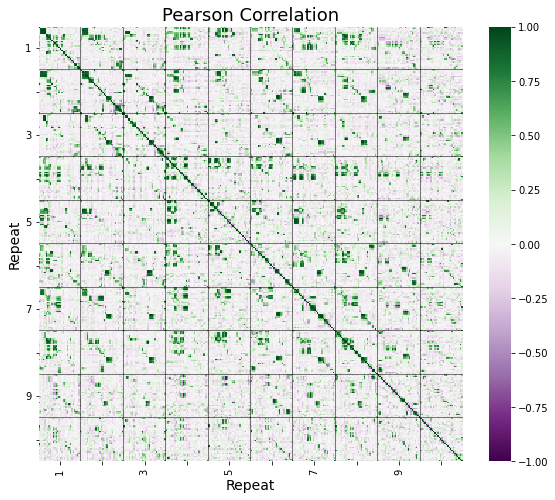

In [28]:
# plot correation, repeats ordered by TIME:
visualize_drift.plot_corr(corrs_s, n_repeat_plot= 10)

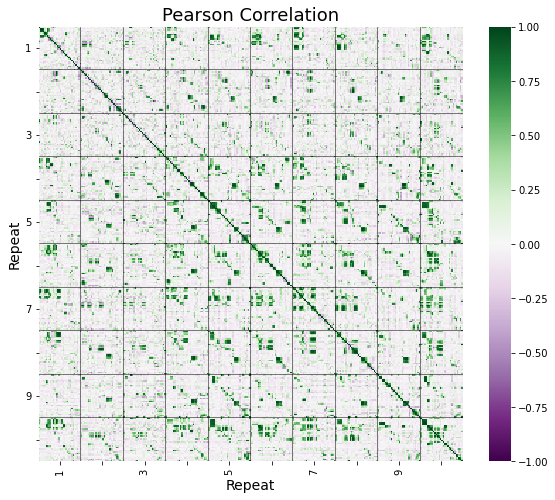

In [29]:
# plot correation, repeats ordered by RUNNING SPEED:
visualize_drift.plot_corr(corrs_ordered, n_repeat_plot= 10)

We see there are more correlation in general, both diagonal and off-diagonal, for the repeats that have higher running speed. Let's visualize the distribution of the R values, split by the faster running 5 sessions, and the slowlier running 5 sessions.

In [30]:
corrs_ordered_triu = np.triu(corrs_ordered, k = 1)

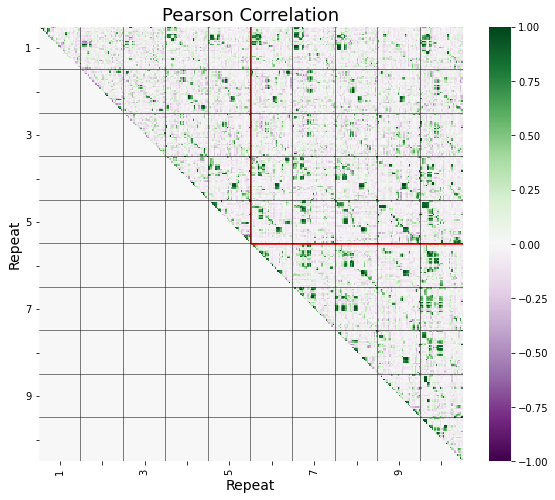

In [31]:
n_repeat_plot = 10
_, ax = plt.subplots(1, 1, figsize=(9.5,8))

sns.heatmap(corrs_ordered_triu[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs], 
            cmap = 'PRGn', vmin = -1, vmax = 1,
            ax = ax)

tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)

tick_labels = [1, None, 3, None, 5, None, 7, None, 9, None]

ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Repeat', fontsize = 14)
ax.set_ylabel('Repeat', fontsize = 14)
ax.set_title('Pearson Correlation', fontsize = 18)

for repeat_idx in range(1, n_repeat_plot):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)

ax.hlines(5*n_divs, 5*n_divs, 300, color = 'r')
ax.vlines(5*n_divs, 0, 5*n_divs, color = 'r')


plt.show()

We split the R-values into 3 bins, indicated by the red line in the above matirx, which are `within_no_run`, `across_bins` and `within_run` respectively. 

In [32]:
within_no_run_bin = corrs_ordered_triu[0*n_divs:5*n_divs, 0*n_divs:5*n_divs]
within_run_bin = corrs_ordered_triu[5*n_divs:, 5*n_divs:]
across_bins = corrs_ordered_triu[0*n_divs:5*n_divs, 5*n_divs:]

In [33]:
within_no_run_bin_flat = within_no_run_bin.flatten()
within_no_run_bin_ff = within_no_run_bin_flat[np.where(within_no_run_bin_flat != 0)] # get rid of lower tri. that we set to zero

within_run_bin_flat = within_run_bin.flatten()
within_run_bin_ff = within_run_bin_flat[np.where(within_run_bin_flat != 0)]

In [34]:
across_bins_flat = across_bins.flatten()

Let's plot the distribution; if we zoom in to focus on above `.25` which is simply an arbitrary cut-off for at least week positive correlation, we see that  the PDF of `within_run` correlation is above `across_bins` and above `within_no_run`.

/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

<AxesSubplot:ylabel='Density'>

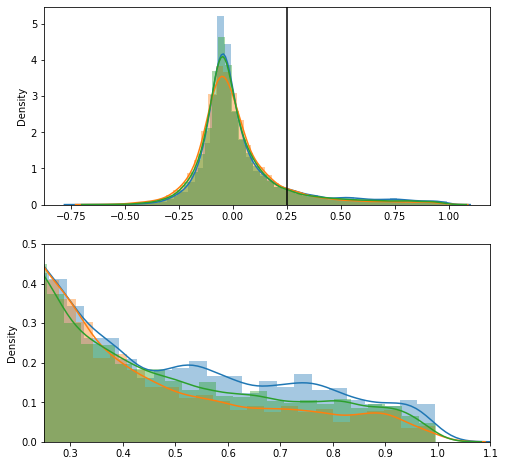

In [35]:
# sns.histplot(across_bins_flat)

fig, ax = plt.subplots(2, 1, figsize = [8,8])

sns.distplot(within_run_bin_ff, kde = True, ax = ax[0])
sns.distplot(within_no_run_bin_ff, kde = True,  ax = ax[0])
sns.distplot(across_bins, kde = True,  ax = ax[0])
ax[0].axvline(.25, color = 'k')


ax[1].set_xlim([.25, 1.1])
ax[1].set_ylim([0,.5])
sns.distplot(within_run_bin_ff, kde = True, ax = ax[1])
sns.distplot(within_no_run_bin_ff, kde = True,  ax = ax[1])
sns.distplot(across_bins, kde = True,  ax = ax[1])

The mean correlation is also higher for the faster running sessions:

In [36]:
within_run_bin_ff.mean()

0.04739627738695116

In [37]:
across_bins.mean()

0.029544036397350974

In [38]:
within_no_run_bin_ff.mean()

0.017756900317769164

This kind of suggests that when the animal runs, the correlation of response vectors, regardless whether it's representing the same stimuli or not, is higher. 

We need to make sure if this is driven by the similarity of the response vectors to the same stimuli first. 

But the overall trend holds, then our result is subtly different from that of the Sadeh & Clopath paper: that behavior not only modulates the variability of representation for the same stimulus, but also modulates the correlation between representations of different stimuli.